# CS 583 Lecture 13: Wavetable Synthesis and Phase Vocoder



Creating a wavetable from a real signal and using interpolation to resample to create arbitrary frequencies.

 

### Utility Code

In [1]:
# General useful imports
import numpy as np
import matplotlib.pyplot as plt
import librosa 
import librosa.display
from IPython.display import Audio

import plotly.graph_objects as go

from scipy import signal

from scipy.signal import resample,resample_poly
from scipy.interpolate import interp1d

%matplotlib inline

# Basic audio parameters

SR            = 22050                  #  sample rate default for Librosa

# Utility functions

# Round to 4 decimal places

def round4(x):
    return np.around(x,4)   

path = "/Users/waynesnyder/Documents/Teaching/CS583/Audio Files/"
    

### Creating Audio Signals

In [2]:
def makeSignal(S=[(440,1,0)], A = None, duration=1.0,sr=SR):
    X = np.zeros(int(sr*duration)) 
    T = np.arange(int(sr*duration))
    for (f,amp,phi) in S:         
        X +=  amp * np.sin( 2 * np.pi * f * T / sr + phi )
    X / max(X)         # normalize to amplitude 1.0
    if(A == None):
        return  X       
    else:
        return  A * X    

In [3]:
# create a dictionary of piano key frequencies

# see https://en.wikipedia.org/wiki/Piano_key_frequencies

notenames = ['A0', 'Bb0', 'B0', 'C1', 'C#1', 'D1', 'Eb1', 'E1', 'F1', 'F#1',
       'G1', 'Ab1', 'A1', 'Bb1', 'B1', 'C2', 'C#2', 'D2', 'Eb2', 'E2',
       'F2', 'F#2', 'G2', 'Ab2', 'A2', 'Bb2', 'B2', 'C3', 'C#3', 'D3',
       'Eb3', 'E3', 'F3', 'F#3', 'G3', 'Ab3', 'A3', 'Bb3', 'B3', 'C4',
       'C#4', 'D4', 'Eb4', 'E4', 'F4', 'F#4', 'G4', 'Ab4', 'A4', 'Bb4',
       'B4', 'C5', 'C#5', 'D5', 'Eb5', 'E5', 'F5', 'F#5', 'G5', 'Ab5',
       'A5', 'Bb5', 'B5', 'C6', 'C#6', 'D6', 'Eb6', 'E6', 'F6', 'F#6',
       'G6', 'Ab6', 'A6', 'Bb6', 'B6', 'C7', 'C#7', 'D7', 'Eb7', 'E7',
       'F7', 'F#7', 'G7', 'Ab7', 'A7', 'Bb7', 'B7', 'C8', 'R']

# Create chromatic scale, e.g., as on the piano, as a dictionary    

Freqs = {} 

f = 27.5

for name in notenames:
    Freqs[name] = f
    f *= 2**(1/12)

Freqs['R'] = 0                    # a rest (silence) 

# test

Freqs['C8']

4186.009044809592

In [4]:
# convert Hz different to cents

cent = 2 ** (1/1200)

def HzDiff2Cents(f,f1):       # f is reference, f1 is observed

    flog = np.log(f)
    f1log = np.log(f1)

    return (f1log - flog) / (cent - 1.0)

# test

#f = Freqs['A4']
#f1 = Freqs['Ab4'] 

#HzDiff2Cents(f,f1)

In [5]:
# get signal array and sample rate from a local audio file, will resample to default SR of 22050

import soundfile as sf
import io
import warnings

from six.moves.urllib.request import urlopen

def readSignal(name,sr=None):    
    if(name[:5] == 'https'):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            X, fileSR = sf.read(io.BytesIO(urlopen(name).read()))           
    else:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            X, fileSR = librosa.load(name)
    if((sr == None) or (fileSR == sr)):
        return X
    else:
        return librosa.resample(X,fileSR,SR) 

# write signal array out to a file in your local directory (or to complete path name)

def writeSignal(name,data,sr=SR):
    sf.write(name,data,sr)

In [6]:
import contextlib
import wave
import array

# I/O for Wave files

# Read a mono wave file from a local file and return the entire file as a 1-D numpy array

def readWaveFile(infile,withParams=False,asNumpy=True):
    with contextlib.closing(wave.open(infile)) as f:
        params = f.getparams()
        frames = f.readframes(params[3])
        if(params[0] != 1):
            print("Warning in reading file: must be a mono file!")
        if(params[1] != 2):
            print("Warning in reading file: must be 16-bit sample type!")
        if(params[2] != 44100):
            print("Warning in reading file: must be 44100 sample rate!")
    if asNumpy:
        X = array.array('h', frames)
        X = np.array(X,dtype='float32')
    else:  
        X = array.array('h', frames)
    if withParams:
        return X,params
    else:
        return X

# Write out an array as a wave file to the local directory
        
def writeWaveFile(fname, X):
    X = [clip(x) for x in X]
    params = [1,2, SR , len(X), "NONE", None]
    data = array.array("h",X)
    with contextlib.closing(wave.open(fname, "w")) as f:
        f.setparams(params)
        f.writeframes(data.tobytes())
    print(fname + " written.")



### Two functions for displaying waveforms

In [7]:
# Display 


def displaySignal(X, sr=SR, title='Signal Window for X',x_units = "Seconds", figsize=(14,6),gridlines=False): 
    
    if(x_units == "Seconds"):
        T = np.arange(0, len(X)/sr, 1/sr)
    elif(x_units == "Milliseconds"):
        T = np.arange(0, 1000*len(X)/sr, 1000/sr)
    elif(x_units == "Samples"):
        T = np.arange(len(X))

    plt.figure(figsize=figsize)   # Set x and y dimensions of window: may need to redo for your display
    plt.title(title, fontsize=14, fontweight='bold')
    if(x_units=="Samples"):
        plt.xlabel("Sample Number")
    else:
        plt.xlabel(x_units)
    plt.ylabel("Amplitude")
    plt.ylim([-1.1,1.1])
    plt.plot([0,T[-1]],[0,0],color='black')      # draw the 0 line in black
    plt.plot(T,X)                    
    plt.grid(gridlines)                     # if you want dotted grid lines
    plt.show()
    
# test

# f = 10
# X = makeSignal([(10,1,0)])
# displaySignal(X,gridlines=True)

# displaySignal(X,x_units="Samples")

# displaySignal(X,x_units="Milliseconds")


In [8]:
# display the waveform

def displaySignal2(x,sr=SR,title='Signal X',):
    plt.figure(figsize=(12,6))
    plt.title(title)
    plt.ylim([-1.1,1.1])           # if you want the full range -1 .. 1, else will adapt to signal
    plt.plot([0,librosa.get_duration(x)],[0,0],linewidth=1,color='k') # if you want a 0 line
    #plt.grid()                    # if you want gridlines
    librosa.display.waveshow(x,sr=sr)
    plt.show()
    
# X = readSignal(k + "trumpet_A4_1_forte_normal.wav")

# displaySignal(X)

### Fast Fourier Transform

The following returns the real spectrum of a signal (amplitude only, no phase) as an array of floats of length $\lfloor N/2\rfloor + 1$ for frequencies 0, f, 2f, ..., up to the Nyquist limit (half the sample rate). 

In [9]:
def realFFT(X):
    return 2*abs(np.fft.rfft(X))/len(X) 

# test

# X = makeSignal(S=[(220,0.5,0),(440,0.3,0),(880,0.2,0),(1100,0.1,0),],duration = 0.19)

# S = realFFT(X)

# print("window frequency", round4(1/0.19))

# print("220 =",220/(1/0.19), "*", round4(1/0.19))
# print()

# for i in range(35,50):
#     print("S["+str(i)+"]:",S[i])

# plt.figure(figsize=(12,6))
# plt.plot(S)
# plt.show()

In [10]:
# We can also return a list of triples of form  [f, A, phi] for each frequency
# f detected by the transform, however, note that, due to floating-point error, 
# you will get extremely small values instead of 0.0 for most of the frequencies; 
# therefore allow the option of filtering out these values using np.isclose(...)
    
def spectrumFFT(X,filterZeros=True):
    R =  np.fft.rfft(X)
    if(filterZeros):
        return np.array([ ( k*SR/len(X), 2.0 * np.absolute(R[k])/len(X),np.angle(R[k])+(np.pi/2) ) 
                            for k in range(len(R)) 
                                if not np.isclose(2.0 * np.absolute(R[k])/len(X),0.0) ]) 
    else:
        return np.array([ ( k*SR/len(X), 2.0 * np.absolute(R[k])/len(X),np.angle(R[k])+(np.pi/2) ) 
                            for k in range(len(R)) ]) 

# test
    
# T = np.arange(SR*0.1)    # duration = 0.1 sec
# SR = 22050
# X = 10000 * np.sin( 2 * np.pi * 1000 * T / SR )
# X += 5000 * np.sin( 2 * np.pi * 3000 * T / SR )
# X += 2500 * np.sin( 2 * np.pi * 5000 * T / SR )

# print(round4(spectrumFFT(X)))
# print()
# S = spectrumFFT(X,False)
# print(round4(S[:5]))
# print()
# print(round4(S[98:104]))
# print()
# print(round4(S[-5:]))

### Inverse FFT

In [11]:
# To create a signal of N samples, must input a spectrum array
# of length N/2 + 1 amplitudes, with the kth frequency bin
# representing the amplitude of frequency k*(SR/N)

def realIFFT(S,A=None):
    S = np.array(S)
    lenX = 2*(len(S)-1)
    complex_S = lenX / 2 * -1.j * S
    X = np.fft.irfft(complex_S)
    if(A == None):
        return X
    else:
        return A * X / max(X)

# test

# S = np.zeros(22050)
# S[220] = 1.0
# S[440] = 0.5
# S[880] = 0.25
# S[1760] = 0.125
# X = realIFFT(S)
# plt.plot(X[:1000])
# plt.show()

# Audio(X,rate=SR)

###  Displaying Instantaneous Spectra

Matplotlib has a useful function to display a spectrum for the whole signal; by giving it
a short "window" you can get the same information contained in one column of the spectrogram:

https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.magnitude_spectrum.html

The term "magnitude spectrum" refers to the fact that we are interested in magnitude
of the various frequencies which make up the signal, instead of the power spectrum (square of the magnitudes) or the phase spectrum (what the phase of the various frequency components are). 


In [12]:
# display the spectrum:   xscale (frequency) can be 'linear' or 'log',
#     and yscale can be 'linear' or 'dB' (essentially log)

def displaySpectrum(X,sr=SR,title='Spectrum of X',xscale='linear',yscale='dB'):
    plt.figure(figsize=(12,6))
    plt.title(title)
    plt.magnitude_spectrum(X,sr,scale=yscale)
    if(xscale == 'linear'):
        plt.xlabel('Frequency (linear)')
    else:    
        plt.xlabel('Frequency (log)')
    if(yscale == 'linear'):
        plt.ylabel('Magnitude (linear)')
    else:    
        plt.ylabel('Magnitude (dB)')
    plt.xscale(xscale)
    plt.show()
    
    
# # Example: Create a signal with a simple spectrum

# X_trumpet = readSignal(path + "trumpet_A4_1_forte_normal.wav")

# # displaySignal(X,title="Signal X: Trumpet playing note A4 = 440 Hz")

# X_trumpet_01 = X_trumpet[11025:16537]

# # displaySignal(X1,title="Signal X1:  Signal X from 0.5 - 0.75 secs")

# # # display the spectrum   scale is 'linear' or 'dB'
    
# displaySpectrum(X_trumpet_01,title="Instantaneous Spectrum of X_trumpet_01", xscale='linear', yscale='linear')

# displaySpectrum(X_trumpet_01,title="Instantaneous Spectrum of X_trumpet_01",xscale='linear', yscale='dB')

# displaySpectrum(X_trumpet_01,title="Instantaneous Spectrum of X_trumpet_01",xscale='log', yscale='linear')

# displaySpectrum(X_trumpet_01,title="Instantaneous Spectrum of X_trumpet_01",xscale='log', yscale='dB')

### Displaying Spectrograms

We can use `librosa.display.specshow` to show spectrograms, which are heatmaps of
spectra over top. Various parameters can be set, including:

    y_axis :   'linear', 'log', 'mel'

    fmin, fmax :  frequency bounds for the mel frequency spectrogram; defaults are fmin=0 and fmax=SR/2 (Nyquist limit)
    
In addition, the `librosa.stft` function takes parameters

    n_fft :    length of the analysis window in samples; defaults to 2048
    
    hop_length : how many samples the window is moved forward for every spectrum; defaults to n_fft / 4

The following is produces a linear scale on the frequency (Y) axis; notice that the typical linear spacing of harmonics (f, 2f, 3f, 4f, etc.) is shown clearly, and correspond to the instantaneous spectrum with a linear frequency scale shown above. 

In [13]:
# display the spectrogram

# S = np.abs(librosa.stft(X_trumpet))                    # calculate the 2D spectrogram
# Sdb = librosa.amplitude_to_db(S, ref=np.max)   # will show power spectrum in heatmap

# plt.figure(figsize=(12,6))
# plt.title("Spectrogram of Trumpet Signal with Linear Frequency Scale")
# librosa.display.specshow(Sdb, sr=SR, x_axis='time', y_axis='linear')
# plt.colorbar(format='%+2.0f dB')
# plt.show()

Now we change the frequency scale to a log scale, and we can see that the linear sequence of harmonics gets closer and closer together, just as they do on the log scale spectrum above, and, in fact, on a piano keyboard. 

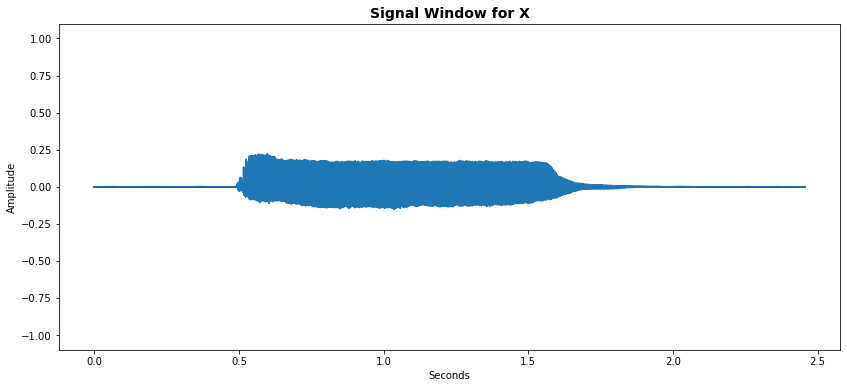

In [14]:
X_clarinet = readSignal('https://www.cs.bu.edu/fac/snyder/cs583/AudioSamples/realClarinet440.wav')
X_oboe = readSignal('https://www.cs.bu.edu/fac/snyder/cs583/AudioSamples/oboe_A4_1_mezzo-forte_normal.wav')
X_guitar = readSignal('https://www.cs.bu.edu/fac/snyder/cs583/AudioSamples/flute_A4_1_mezzo-forte_normal.wav')
X_trumpet = readSignal('https://www.cs.bu.edu/fac/snyder/cs583/AudioSamples/trumpet_A4_1_forte_normal.wav')

displaySignal(X_trumpet)

Audio(X_trumpet,rate=SR)

In [15]:
def corr(X,Y):
    N = len(X)
    return (X @ Y) / (len(X) * np.std(X) * np.std(Y))

def acorrK(X,lag):
    N = len(X)    
    return corr( X[:N-lag], X[lag:] )



def acorr(X):
    N = len(X)
    return np.array(  [  acorrK(X,k) for k in range(N//2) ]  )

In [16]:
def find_peaks(A,relative_threshold=0.75): 
    absolute_threshold = relative_threshold * max(A)       
    peaks = []
    for t in range(10,len(A)-1):             
        if A[t-1] < A[t] and A[t] > A[t+1] and A[t] >= absolute_threshold:
            peaks.append(t)
    return np.array(peaks)

In [17]:
def acorr_plot(X,relativeThreshold = 0.75, display=True, results = False):
    
    A = acorr(X)
        
    Xp = find_peaks(A,relativeThreshold)

    Yp = [ A[k] for k in Xp ]

    if display:
        plt.figure(figsize=(12,4))
        plt.title("Signal X")
        plt.plot(X)
        plt.plot([0,len(X)],[0,0],color='k')
        plt.grid()
        plt.show()

        plt.figure(figsize=(12,4))
        plt.title("Autocorrelation Plot of X")
        plt.plot(A)
        plt.scatter(Xp,Yp,color='r')
        plt.plot([0,len(X)],[0,0],color='k')
        plt.grid()
        plt.show()
    
    if(results):
        return (A,Xp,Yp)


In [18]:
def parabolicInterpolationPeak(xs,ys):
#     print(xs,ys)
    [x1, x2, x3 ] = xs
    [y1, y2, y3 ] = ys
    denom = (x1 - x2) * (x1 - x3) * (x2 - x3)
    A     = (x3 * (y2 - y1) + x2 * (y1 - y3) + x1 * (y3 - y2)) / denom
    B     = (x3*x3 * (y1 - y2) + x2*x2 * (y3 - y1) + x1*x1 * (y2 - y3)) / denom
    x = -B / (2*A)
#     f = interp1d(xs,ys,kind='quadratic')
#     return  (x,f(x))
    return x

In [19]:

def acorr_pitch_interpolate(X,sr=SR,relative_threshold=0.75,display=True):
    
    (A,Xp,Yp) = acorr_plot(X,relative_threshold, display=display,results=True)
   
    xs = [ Xp[0]-1, Xp[0], Xp[0]+1 ]
    ys = [ A[Xp[0]-1], A[Xp[0]], A[Xp[0]+1] ]
    
    period = parabolicInterpolationPeak( xs, ys )
    f0 = sr/period
    return (A,Xp,Yp,period,f0)

## Lecture 13:  Wavetables and the Phase Vocoder


### Wavetables


A *wavetable* is a data structure containing exactly one period of a periodic signal.
This can be stretched or shrunk using interpolation to create different frequencies; it can
also be manipulated in a variety of ways to create new sounds. 

There are several stages to creating an using a wavetable:

1. Find a window in the signal with as much tonal information as possible (continuous tone at constant amplitude, no vibrato);

2. Find the fundamental frequency $f_0$. 

3. Extract one period from the window, and interpolate to create exactly one period in an integer number of samples (period was probably NOT an integer) (we will use $N=50$); this is the **wavetable**. 

4. To create a signal from the wavetable, interpolate to create a freuency $f$ and concatenate as many periods as necessary to create the signal; this may then be modified in other ways, such as with an ASDR envelope. 

#### Step One: Extract a window

Here we will use the `realClarinet.A4.wav` file. 

length: 36288


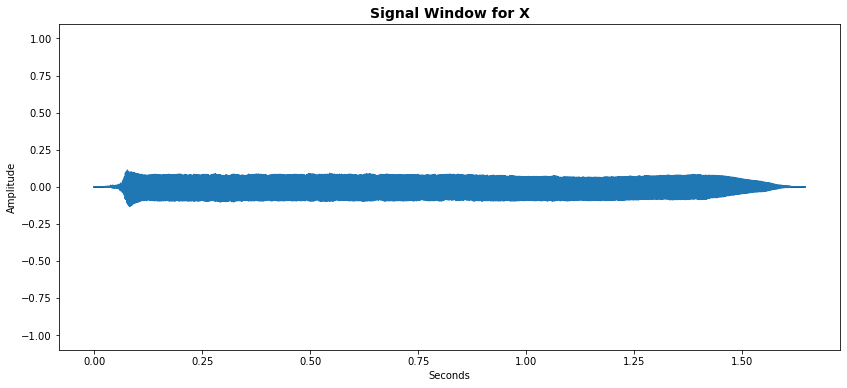

In [20]:
X_clarinet = readSignal(path + 'realClarinet.A4.wav')   



print("length:", len(X_clarinet))
displaySignal(X_clarinet)
Audio(X_clarinet,rate=SR)


length:  11025


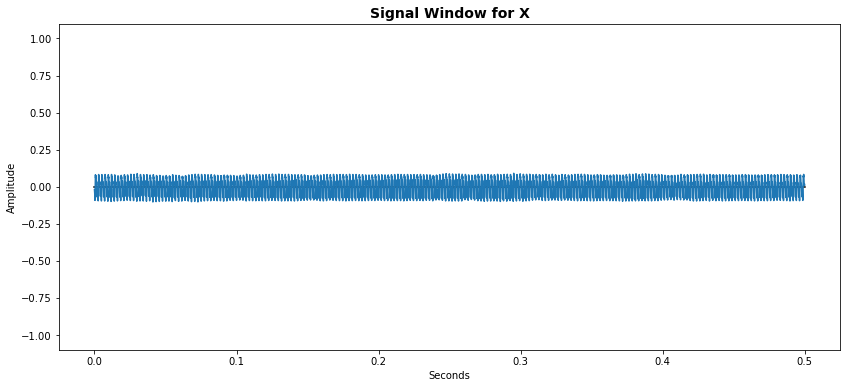

In [21]:
# one half second window of clarinet signal from 0.25 to 0.75

X = X_clarinet

start = int(SR*0.25)
end = int(SR*0.75)

clarinet_sample = X_clarinet[start:end]

print("length: ",len(clarinet_sample))
displaySignal(clarinet_sample)
Audio(clarinet_sample,rate=SR)

### Step Two: Find the Fundamental Frequency $f_0$

Turns out, our AC + poly interpolation works very well, at least on simple signals like the clarinet!

Here we compare it with the librosa implementation of the famous pitch determination algorithm **Yin**. 

In [22]:
# C = clarinet_sample / max(clarinet_sample)
#print(len(C))

(A,Xp,Yp,period,f0) = acorr_pitch_interpolate(clarinet_sample,sr=SR,display=False)

AC_f0 = f0

print("AC plus PolyInterpolation f0 = ", AC_f0)

AC plus PolyInterpolation f0 =  441.4860076866511


### DIGRESSION:  How accurate is our pitch-determination algorithm?

We will compare with Yin and also display a "3D plot" of the signal.

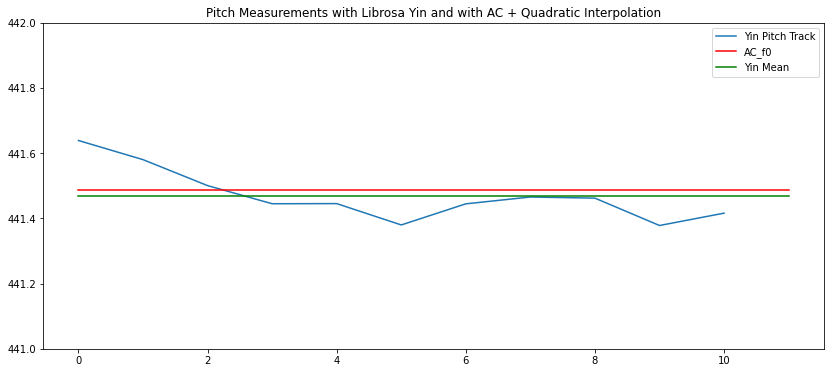

Librosa Yin mean f0:  441.4685683036665
AC + Quad Interp f0:  441.4860076866511
Difference:  0.0684 cents


In [23]:

N = len(clarinet_sample)

F = librosa.yin(clarinet_sample.astype('float32'),fmin=400,fmax=500,sr=44100)

plt.figure(figsize=(14,6))
plt.title("Pitch Measurements with Librosa Yin and with AC + Quadratic Interpolation")
plt.ylim(441,442)
plt.plot(F[10:-1],label="Yin Pitch Track")

m = np.mean(F[10:-1])
plt.plot([0,len(F[10:-1])],[AC_f0,AC_f0],color='r',label="AC_f0")
plt.plot([0,len(F[10:-1])],[m,m],color='g',label="Yin Mean")
plt.legend()
plt.show()

print("Librosa Yin mean f0: ", m)
print("AC + Quad Interp f0: ", AC_f0)
print("Difference: ",round4(HzDiff2Cents(m,AC_f0)), "cents")

In [24]:
N

11025

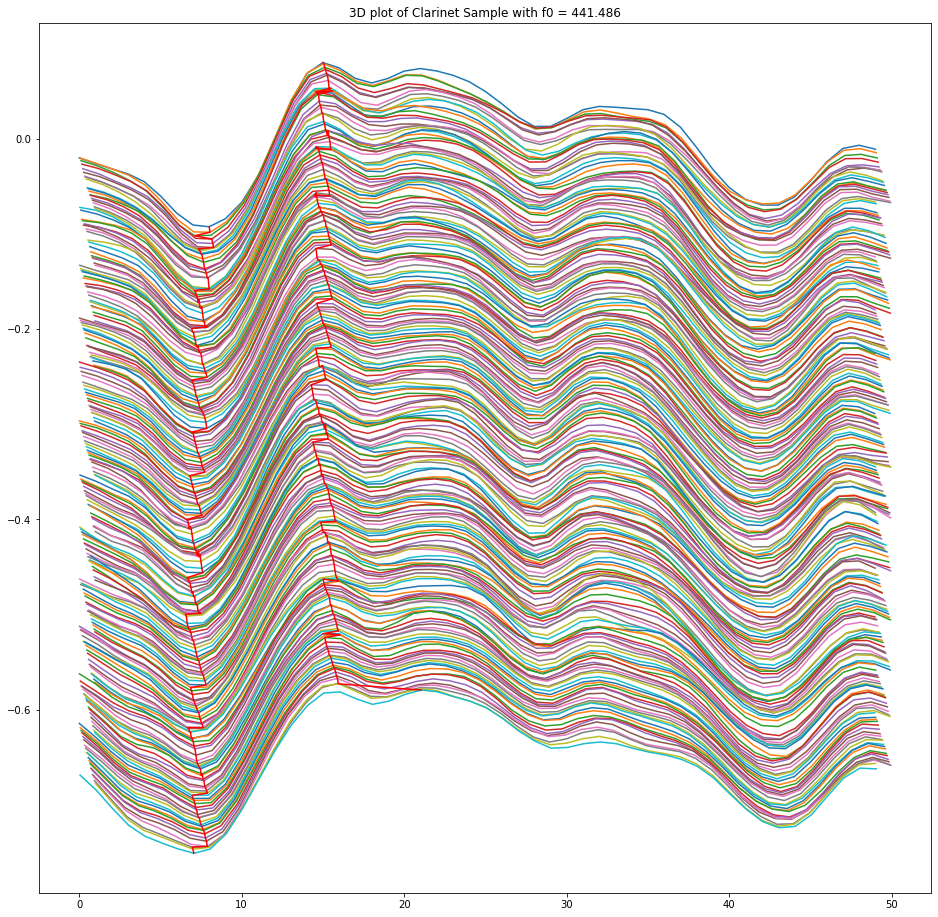

In [25]:
f = AC_f0
period = SR/f
row_length = int(np.ceil(period))

delta = 0.003

M = N//row_length

#print(N,f,period,row_length,M)

T = np.arange(0,N)

TOPX = []
TOPY = []
BOTX = []
BOTY = []

# X,Y,Z = [],[],[]



plt.figure(figsize=(16,16))
plt.title("3D plot of Clarinet Sample with f0 = " + str(round4(AC_f0)))
for k in range(M):
    lo = np.searchsorted(T,k*period)
    hi = np.searchsorted(T,(k+1)*period)    
    T1 = T[lo:hi] 
    T2 = T1 - k*period
    X1 = np.array([clarinet_sample[i] for i in T1]) - k*delta
    plt.plot(T2,X1)  
    
#     for i in range(len(T2)):
#         X.append(T2[i])
#         Z.append(X1[i])
#         Y.append(k)
    
    top = np.argmax(X1)
    TOPX.append(T2[top])
    TOPY.append(X1[top])
    
    bot = np.argmin(X1)
    BOTX.append(T2[bot])
    BOTY.append(X1[bot])
    
#     T1 = T[k*50:(k+1)*p] % p
#     print(len(T1))
#     X1 = clarinet_sample[k*50:(k+1)*p]-k*delta
#     plt.plot(T1,X1)

plt.plot(TOPX,TOPY,color='r')
plt.plot(BOTX,BOTY,color='r')
plt.show()


        

In [26]:

# fig = go.Figure(data=[go.Surface(z=Z[:50], x=X[:50], y=Y[:50])])
# fig.update_layout(title='3D Signal Frequency', 
#                   xaxis_title="Frequency Differential",
#                   yaxis_title="Phase Differential",
#                   autosize=True,
#                   width=1000, height=1000,
#                   margin=dict(l=65, r=50, b=65, t=90)
#                  )


# fig.show()

**End of Digression!**


### Step 3: Extract one period and interpolate to N samples

We will use N = 100 for example (could be larger). 

The period of a 441.486 Hz signal is 49.945 cycles. We will resample so it is exactly 50 samples.

Here are the first 50 samples, with max amplitude = 1.0. 

In [27]:
period

49.94495774744961

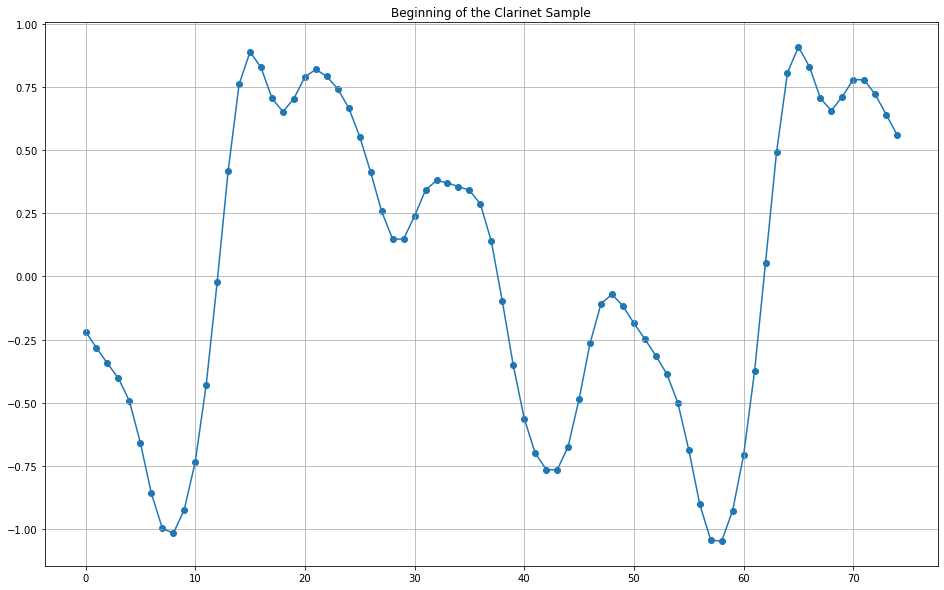

In [28]:
P = 75

clarinet_wavetable = clarinet_sample[:N] 

clarinet_wavetable = clarinet_wavetable / max(clarinet_wavetable) 

T = np.arange(P)

plt.figure(figsize=(16,10))
plt.title("Beginning of the Clarinet Sample")
plt.plot(T,clarinet_wavetable[:P])
plt.scatter(T,clarinet_wavetable[:P])
plt.grid()
plt.show()

W: 51


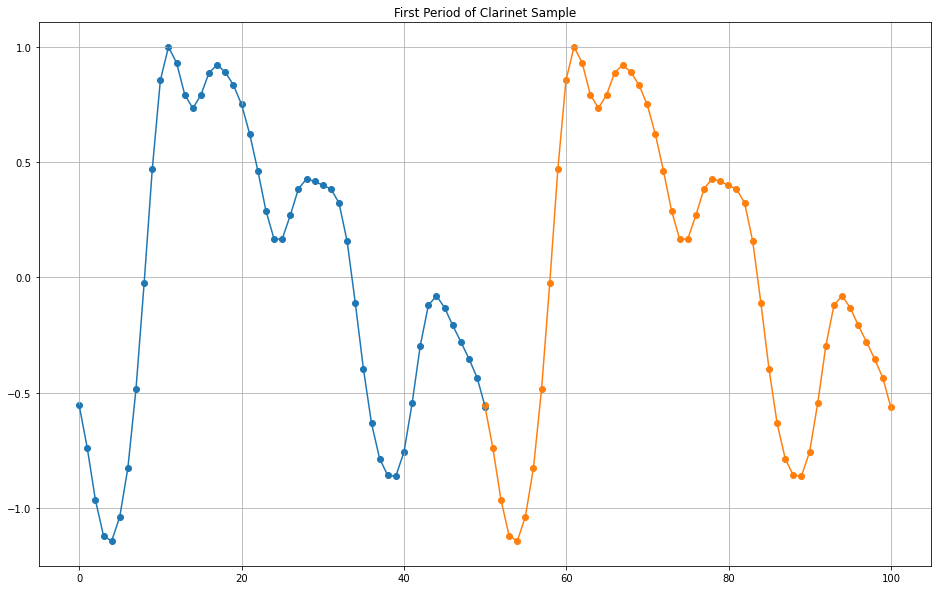

In [29]:
  

#period = 49.9449577474496     # determined by AC + quad interp
#period = 50

#print(len(X_clarinet))


W = int(np.ceil(period))  + 1              # we need an extra sample at end to do interpolation        
                                           # The period is 49.944 so we need samples 0 .. 50 to 
                                           # cover the interpolation range
        
wt_start = 4                               # pick a location to start where values line up              
wt_end = W + 4 

print("W:",W)

clarinet_one_period = clarinet_sample[wt_start:wt_end] 

clarinet_one_period = clarinet_one_period/ max(clarinet_one_period)     # max amp to 1.0


T = np.arange(W)

plt.figure(figsize=(16,10))
plt.title("First Period of Clarinet Sample")
plt.plot(T,clarinet_one_period[:N])
plt.scatter(T,clarinet_one_period[:N])
plt.plot(T+period,clarinet_one_period[:N])
plt.scatter(T+period,clarinet_one_period[:N])
plt.grid()
plt.show()

The period is 49.944 so we need samples 0 .. 50 to cover the interpolation range. 

### Step 4: Interpolate to exactly 50 points

Now we will interpolate and resample so that we get EXACTLY one wave in N = 50 samples

[ 0.          0.99889915  1.99779831  2.99669746  3.99559662  4.99449577
  5.99339493  6.99229408  7.99119324  8.99009239  9.98899155 10.9878907
 11.98678986 12.98568901 13.98458817 14.98348732 15.98238648 16.98128563
 17.98018479 18.97908394 19.9779831  20.97688225 21.97578141 22.97468056
 23.97357972 24.97247887 25.97137803 26.97027718 27.96917634 28.96807549
 29.96697465 30.9658738  31.96477296 32.96367211 33.96257127 34.96147042
 35.96036958 36.95926873 37.95816789 38.95706704 39.9559662  40.95486535
 41.95376451 42.95266366 43.95156282 44.95046197 45.94936113 46.94826028
 47.94715944 48.94605859]

len(Wavetable): 50


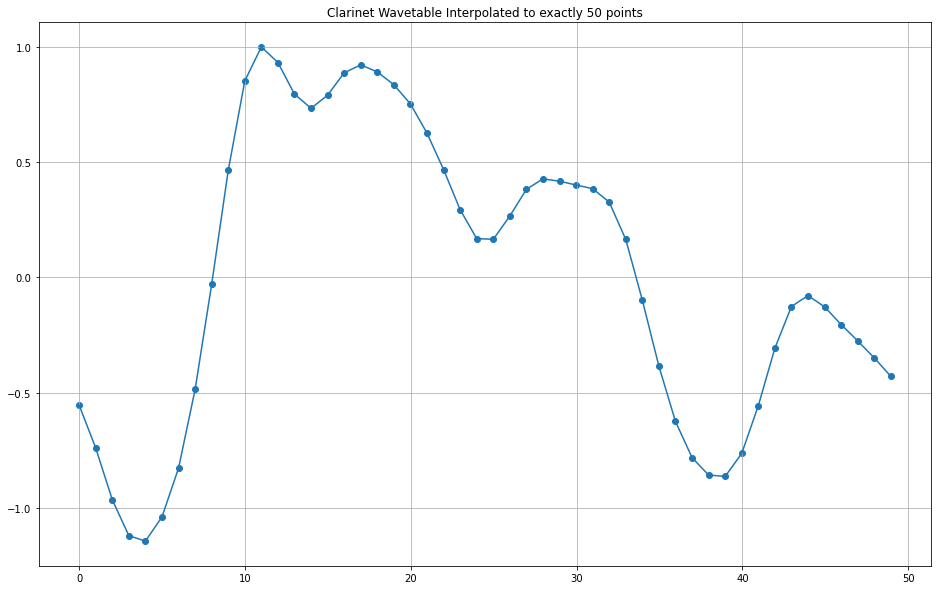

In [30]:
N = 51
W = 51

f = interp1d(range(len(clarinet_one_period)), clarinet_one_period, kind='cubic')

T1 = np.linspace(0,period,N)[:-1]           # eliminate last point, which was only use for interpolation

print(T1)

Wavetable = np.array( [ f(x) for x in T1 ] )

print("\nlen(Wavetable):", len(Wavetable))

plt.figure(figsize=(16,10))
plt.title("Clarinet Wavetable Interpolated to exactly 50 points")
plt.plot(T1,Wavetable)
plt.scatter(T1,Wavetable)
plt.grid()
plt.show()

### Creating a signal from the Wavetable

Now we may simply concatenate the Wavetable as many times as we want to create
a signal at a given frequency, represented in the wavetable, here that would be
$${SR\over len(\text{Wavetable})} = 441.$$

p = 50
f = 441.0


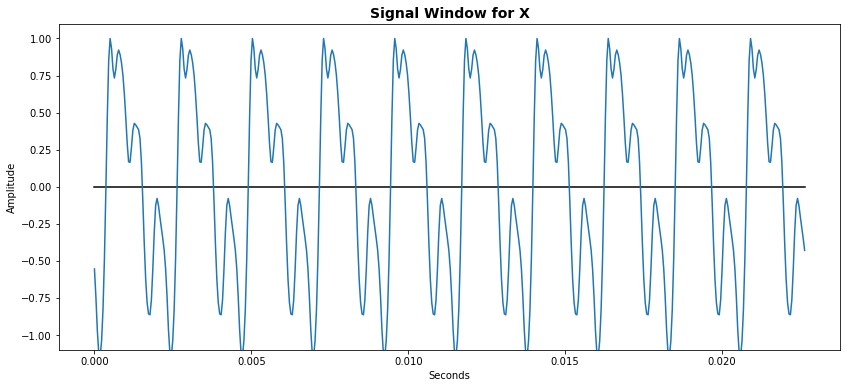

In [31]:
def makeSignalFromWavetable(wavetable,duration=3.0):
    
    p = len(Wavetable)
    f = SR/p
    
    print("p =",p)
    print("f =",f)

    wavetable_list = list(wavetable)

    X = []
    d = int(SR*duration)
    for k in range(d//p):
        X += wavetable_list

    return np.array(X)

synthetic_clarinet = makeSignalFromWavetable(Wavetable)
displaySignal(synthetic_clarinet[:500])

Audio(synthetic_clarinet,rate=SR)

## Resynthesizing a Signal from the Wavetable

Here we interpolated to get a standardized wave table of 50 points. 

In order to create a signal at a different frequency, we must interpolate to a new frequency; there are two
methods:

1. **Fourier Interpolation:**  Resample by extending or abbreviating the spectrum.  This is how `librosa.resample` and `scipy.signal.resample` work.   This is the best method because it recreates the waveform using sine waves using the FFT and IFFT.   Disadvantage:  must work with integer number of samples, or a rational fraction of samples. 


2.  **Polynomial (e.g., Quadratic) Interpolation:**  Resample at an arbitrary frequency.  Disadvantage: does not create new wave from sine waves, so quality will be poor if large distance between original and target frequency. 


3.  **Composite method:**  Get as close as possible using Fourier Interpolation and rational factyors, then adjust using Polynomial Interpolation.

##  Multirate Sampling: The Simple Case

When you have a signal of $N$ samples, and want to expand it or contract it by interpolation to a signal with $M$ samples--where both $N$ and $M$ are integers--then you can convert it using the **FFT** into a spectrum, which will have 

$$S\ =\  {N \over 2} + 1$$

spectral bins.  If we resynthesize it, we get back the original signal, which will have

$$N\ =\ {(S-1) \over 2}$$

samples.  However--and this is **the trick**--if we extend the spectrum at the end with $K$ **zeros**
and then resynthesize, we get a signal with

$$N'\ =\ {S+K-1\over 2}$$

samples, which is longer, and has proportionally lower frequencies. 

This is how librosa.resample and scipy.signal.resample work.

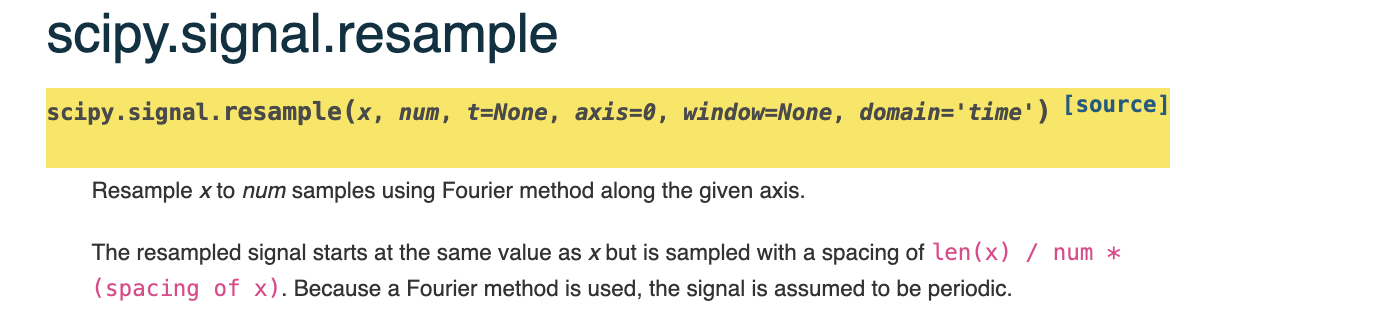


https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample.html#scipy.signal.resample

### Example: Bach Invention #1 on Piano

Length of sample: 110250


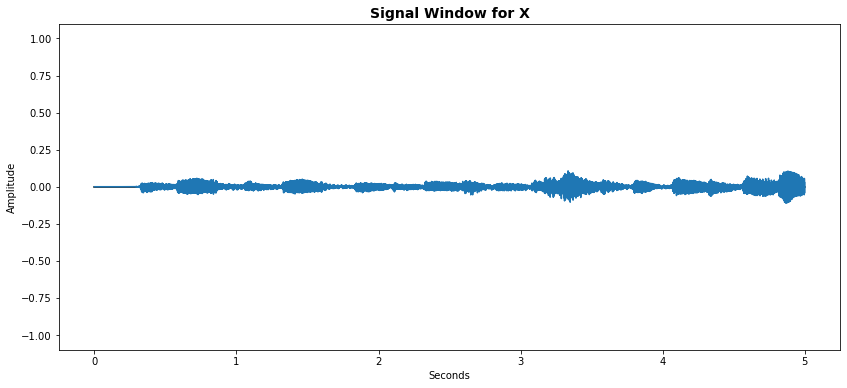

In [32]:
from scipy.signal import resample,resample_poly

# resample takes a signal X with N = len(X) samples and converts it into a signal
# with M samples, using Fourier Interpolation.

X = readSignal(path+'invention.C4.wav',sr=SR)

dur = 5.0

X1 = X[:int(dur*SR)]      # just first 5 seconds for the example

print("Length of sample:", len(X1))

displaySignal(X1)
Audio(X1,rate=SR)

Now let's slow it down by a factor of 2...

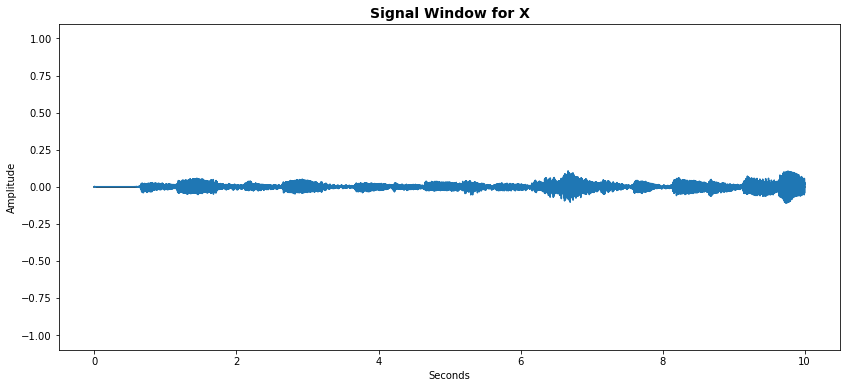

In [33]:
M = 2 * len(X1)

Y1 = resample(X1,M)

displaySignal(Y1)
Audio(Y1,rate=SR)

Now let's speed it up by a factor of 2...

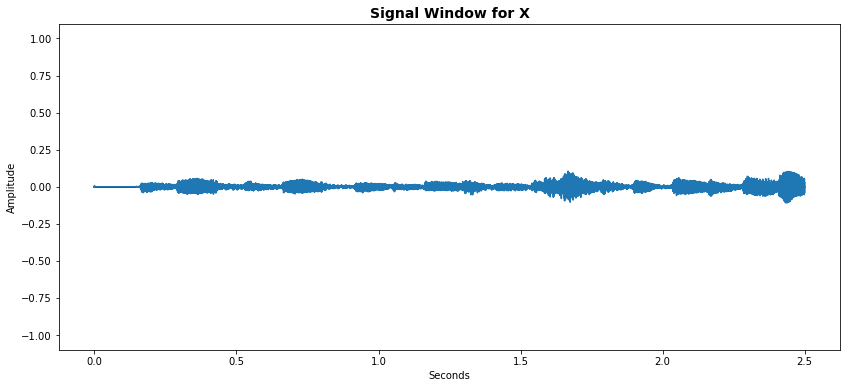

In [34]:
M = len(X1) // 2

Y2 = resample(X1,M)

displaySignal(Y2)
Audio(Y2,rate=SR)

Or by an arbitrary amount.

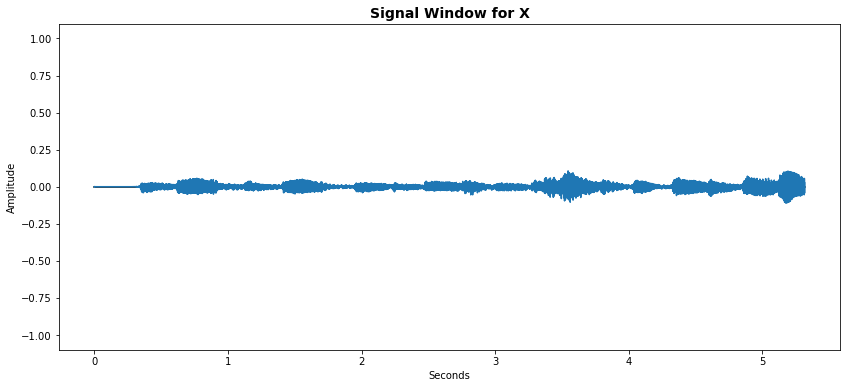

In [35]:
Y2 = resample(X1,117255)

displaySignal(Y2)
Audio(Y2,rate=SR)

##  Multirate Sampling:  The Rational Factor Case

Often, however, you do not care that much about the exact number of
samples in the transformed signal, but care rather about the factor $P$ by which
you expand or contact time in the signal (e.g., $P=1.5$ means the total time
for the clip will be 1.5 times as long, and $P=0.5$ means it will be half as long,
and consequently twice as high in pitch). 

In this case, the trick is to express $P$ as a fraction $up\over down$, where `resample_poly` does the following:

- Upsamples by the factor $up$ by interpolation, so that the signal $X$ is $up$ times as long;
- Applies a filter to get rid of noise introduce by the upsampling; and
- Downsamples (or *decimates*) by the factor $down$, so the theoretical length of the
original signal would be 

$${len(X)\cdot up\over down} \text{ seconds,} $$

which will be fitted into $$\left\lceil {len(X)\cdot up\over down}\right\rceil \text{ samples.} $$

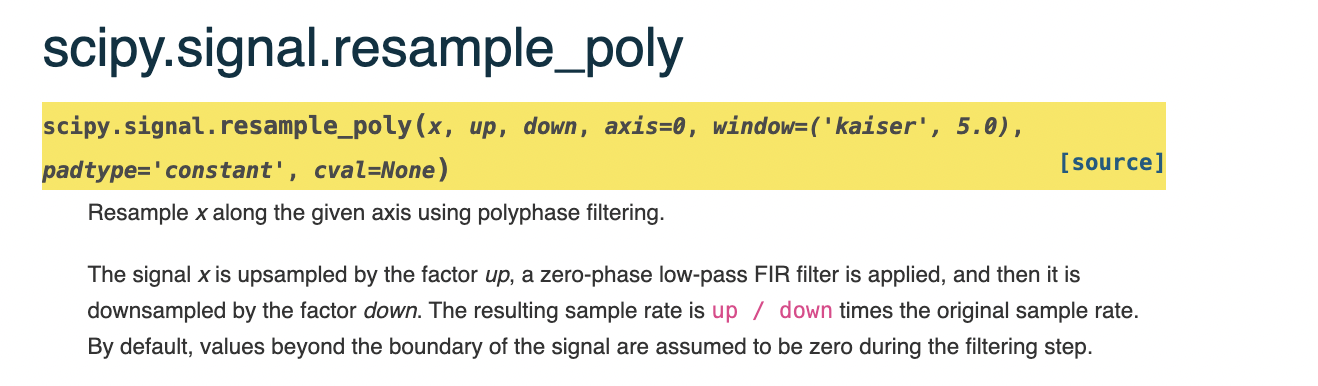

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample_poly.html#scipy.signal.resample_poly


There may be some *boundary conditions* at the end, because
the signal may not fit in a precise number of sample, which should only affect
a small number of samples and not matter with a sample rate of 44.1 KHz. See the example below. 

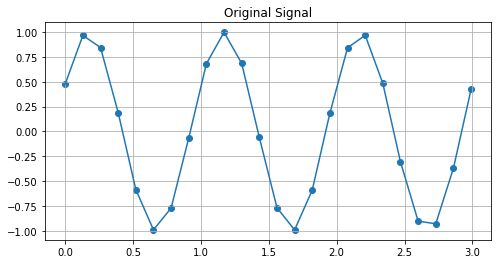

In [36]:
# A simple example showing how it works

X2 = [np.sin(2*np.pi*t+0.5) for t in np.arange(0,3,0.13)]

plt.figure(figsize=(8,4))
plt.title("Original Signal")
plt.plot(np.arange(0,3,0.13),X2)
plt.scatter(np.arange(0,3,0.13),X2)
plt.grid()
plt.show()

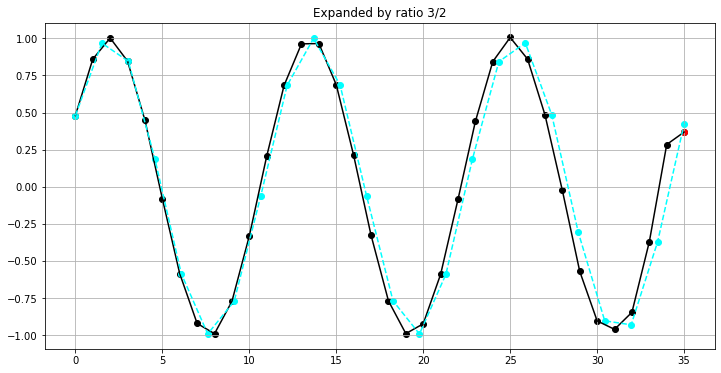

In [37]:
Y4 = resample_poly(X2,3,2)

plt.figure(figsize=(12,6))
plt.title("Expanded by ratio 3/2")
plt.plot(Y4,color='k')
plt.scatter(range(len(Y4)),Y4,color='k')
plt.plot(np.linspace(0,len(Y4)-1,len(X2)),X2,color='cyan',linestyle='--')
plt.scatter(np.linspace(0,len(Y4)-1,len(X2)),X2,color='cyan')
plt.scatter([len(Y4)-1],[Y4[len(Y4)-1]],color='r')
plt.grid()
plt.show()

### Example: Steel String Guitar

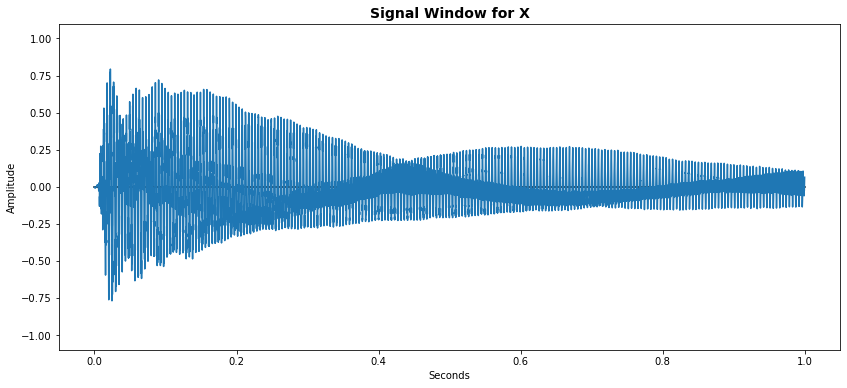

In [38]:
# Get first second of guitar signal
Xguitar = (readSignal(path+'SteelString.wav'))[:22050]
N = len(Xguitar)
dur = N/SR

displaySignal(Xguitar)
Audio(Xguitar,rate=SR)

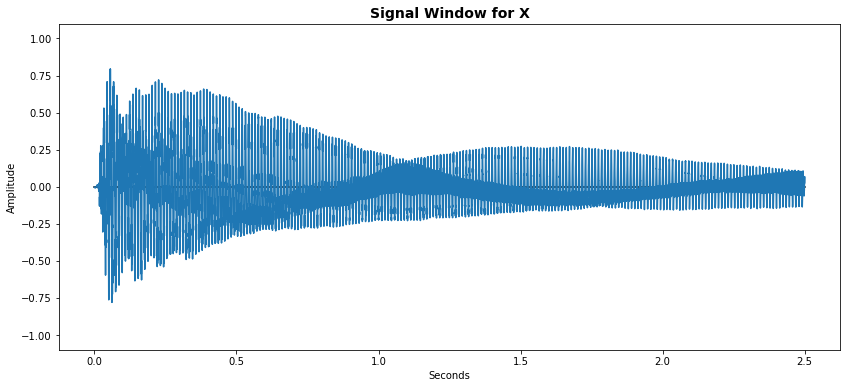

In [39]:
# Resample at 5/2, so slowed down by 2.5 (2.5x as long)

Y5 = resample_poly(Xguitar,5,2)
displaySignal(Y5)
Audio(Y5,rate=SR)

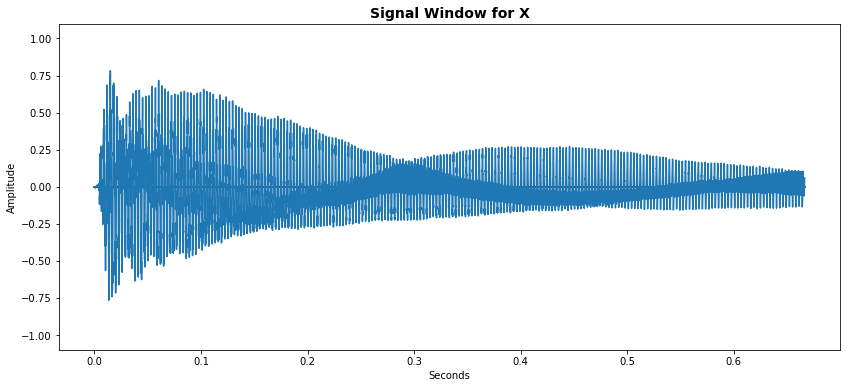

In [40]:
# Resample at 2/3, so speeded up by 1.5 (length is 2/3 of previous)

Y6 = resample_poly(Xguitar,2,3)
displaySignal(Y6)
Audio(Y6,rate=SR)

## Phase Vocoder: Unlocking Pitch and Time

We may now use the rational-factor method `interpolate_poly`
to stretch or shrink the time by a floating-point factor $P$. In other words,
we are going to approximate the inefficient case with a more efficient case,
at the risk of being slightly off (since $P$ has to be presented as a numerator
and denominator). This is generally not a problem, unless we are using
this method for sliding windows, in which case the phase will be a little off. 

### Part (A) (Time Stretching by Interpolation)

In [41]:
# Convert a float factor P to a fraction N/M which is as close as possible. 
# You may assume that P has at most 1 significant digit after the decimal point

def timeStretch(X,P):
    num = int(P*10)
    denom = 10
    return resample_poly(X,num,denom)
    
# Test it on the following example    

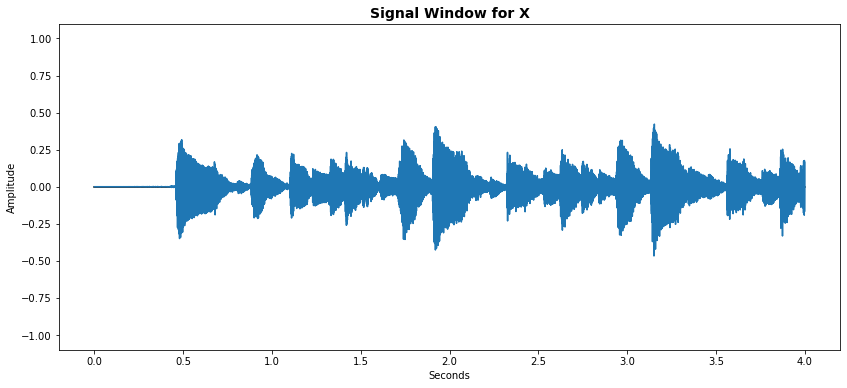

In [42]:
Tigran = readSignal(path+"Tigran_Hamasyan.wav")

TigranShort = Tigran[:SR*4]
displaySignal(TigranShort)
Audio(TigranShort,rate=SR)

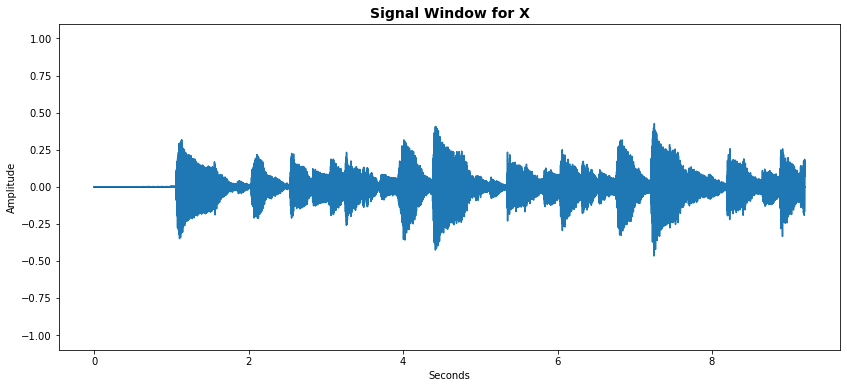

In [43]:
Y1 = timeStretch(TigranShort,2.3)


displaySignal(Y1)
Audio(Y1,rate=SR)

### Part (B) (Phase Vocoder)

The phase vocoder works by stretching and combining individual windows, adjusting the phase along the way. 

In [44]:
# P is increase factor:  for time mode, P is expansion factor for duration
# for pitch, P indicates increase/decrease in pitch, e.g., P = 2 gives octave higher
# mode is 'time or 'pitch' (default is time)

def pitchStretchUnlocked(X,P,mode='time'):

    N = 2048       # window size for FFT
    H = N//4       # skip size -- how far the window advances at each step
    
    tscale = 1.0/P

    # signal blocks for processing and output
    phi  = np.zeros(N)
    out = np.zeros(N, dtype=complex)
    Y = np.zeros(int(len(X)/tscale+N))

    # max input amp, window
    amp = max(X)
    win = signal.windows.hann(N)

    # p is beginning of window
    p = 0
    pp = 0


    while(p < len(X)-(N+H)):
        #    print(str(p) + "\t" + str(pp))

        # take the spectra of two consecutive windows
        spec1 =  np.fft.fft(win*X[p:p+N])
        spec2 =  np.fft.fft(win*X[p+H:p+N+H])

        # take their phase difference and integrate
        phi += (np.angle(spec2) - np.angle(spec1))
    
        # bring the phase back to between pi and -pi, "wrapped phase"
        for i in range(len(phi)):
            while(phi[i] < -np.pi): 
                phi[i] += 2*np.pi
            while(phi[i] >= np.pi): 
                phi[i] -= 2*np.pi
                
            out.real, out.imag = np.cos(phi), np.sin(phi)
    
        # inverse FFT and overlap-add
        Y[pp:pp+N] += (win*np.fft.ifft(spec2*out)).real

    
        pp += H
        p += int(H*tscale)
    
    if mode == 'pitch':
        Y = timeStretch(Y,1/P)

    return Y

### Example of Phase Vocoder



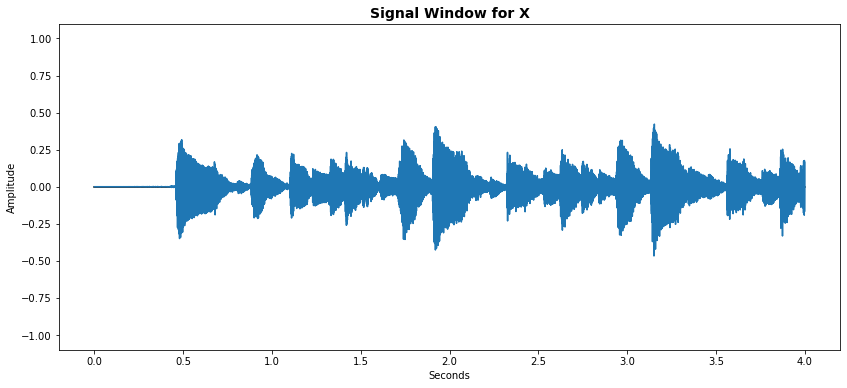

In [45]:
# Original signal
 
displaySignal(TigranShort)

Audio(TigranShort,rate=SR)

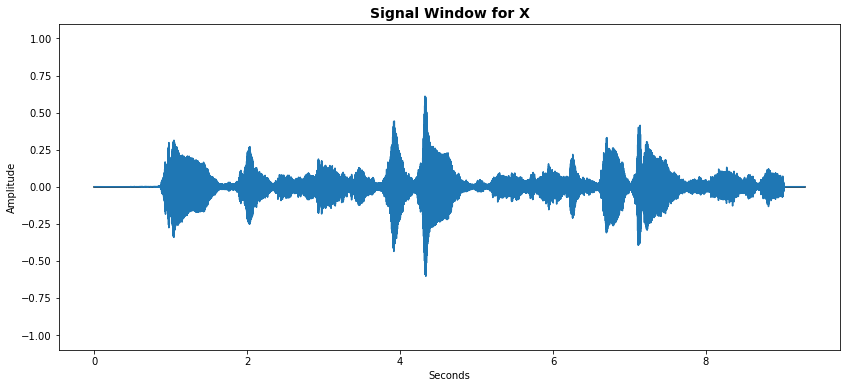

In [46]:
# Lengthen the time by a factor of 2.3 without changing the pitch. 

X = pitchStretchUnlocked(TigranShort,P=2.3)

displaySignal(X)

Audio(X,rate=SR)

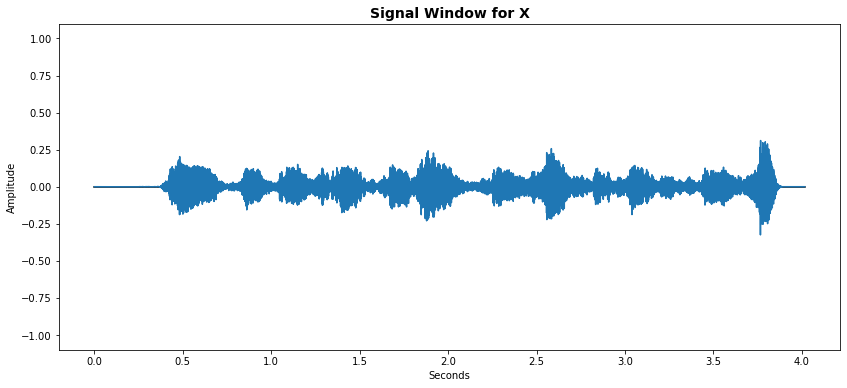

In [47]:
# Decrease the pitch by an octave and a fifth

factor = Freqs['G3']/Freqs['C4']

X = pitchStretchUnlocked(TigranShort,P=factor,mode='pitch')
displaySignal(X)

Audio(X,rate=SR)